# Importing the Libraries

In [69]:
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

**Dataset**

In [2]:
df = pd.read_csv('Hate Speech Detection using Python.csv')

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


# **Data Preprocessing**

In [5]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = nltk.word_tokenize(text)
    # Remove stopwords and perform stemming
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [6]:
df.tweet=df['tweet'].apply(preprocess_text)

In [7]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt woman shouldnt complain clean hous amp man ...
1,1,3,0,3,0,1,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,2,3,0,3,0,1,rt dawg rt ever fuck bitch start cri confus shit
3,3,3,0,2,1,1,rt look like tranni
4,4,6,0,6,0,1,rt shit hear might true might faker bitch told ya


In [8]:
df.shape

(24783, 7)

In [9]:
#Drop duplicates
df= df.drop_duplicates('tweet')

In [10]:
df.shape

(23988, 7)

In [11]:
df['class'].value_counts()

1    18546
2     4070
0     1372
Name: class, dtype: int64

- 0 - hate_speech
- 1 - offensive_language
- 2 - neither

In [13]:
def determine_label(row):
    counts = row[['hate_speech', 'offensive_language', 'neither']]
    max_count = max(counts)
    
    if max_count == row['hate_speech']:
        return 'hate_speech'
    elif max_count == row['offensive_language']:
        return 'offensive_language'
    else:
        return 'neither'

df['label'] = df.apply(determine_label, axis=1)

In [14]:
df=df[["tweet", "label"]]

In [15]:
df.head()

,tweet,label
0,rt woman shouldnt complain clean hous amp man ...,neither
1,rt boy dat coldtyga dwn bad cuffin dat hoe st ...,offensive_language
2,rt dawg rt ever fuck bitch start cri confus shit,offensive_language
3,rt look like tranni,offensive_language
4,rt shit hear might true might faker bitch told ya,offensive_language


<AxesSubplot:xlabel='label', ylabel='count'>

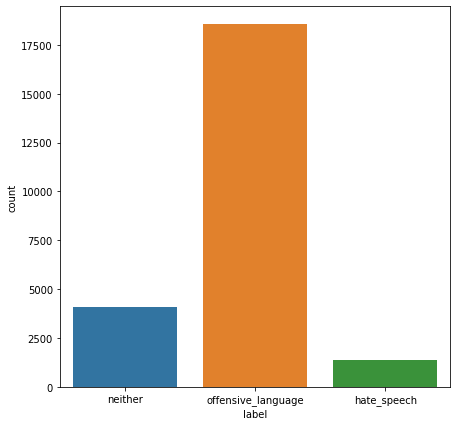

In [16]:
fig = plt.figure(figsize=(7,7))
sns.countplot(x='label',data=df)

**Feature Extraction using TF-IDF Vectorizer**

In [59]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['tweet']).toarray()
y = df['label'].map({'hate_speech': 0, 'offensive_language': 1 ,'neither':2}).values

In [60]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
print(y)

[2 1 1 ... 1 1 2]


# Model Building

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**Split the data into training and testing sets**


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Classification with Support Vector Machine (SVM)**

In [22]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

**Classification with Naive Bayes**

In [23]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

**Classification with Random Forest**

In [24]:
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

**Classification using logistic regression**

In [27]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)
y_pred_logreg = logreg_classifier.predict(X_test)

c:\users\nazim\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Evaluation and Comparison of Algorithms**

In [39]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()
    return accuracy

**SVM Model Performance**

In [76]:
print("Support Vector Machine (SVM) Results:")
evaluate_model(y_test, y_pred_svm, "SVM")

Support Vector Machine (SVM) Results:
SVM Accuracy: 0.9027
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.14      0.22       287
           1       0.92      0.96      0.94      3714
           2       0.83      0.90      0.87       797

    accuracy                           0.90      4798
   macro avg       0.77      0.67      0.68      4798
weighted avg       0.89      0.90      0.89      4798

Confusion Matrix:
[[  39  223   25]
 [  24 3572  118]
 [   7   70  720]]



0.9026677782409337

**Naive Bayes Model Performance**

In [77]:
print("Naive Bayes Results:")
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

Naive Bayes Results:
Naive Bayes Accuracy: 0.8347
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       287
           1       0.83      0.99      0.90      3714
           2       0.90      0.40      0.55       797

    accuracy                           0.83      4798
   macro avg       0.74      0.47      0.49      4798
weighted avg       0.82      0.83      0.79      4798

Confusion Matrix:
[[   1  279    7]
 [   0 3684   30]
 [   1  476  320]]



0.834722801167153

**Random Forest Model Performance**

In [78]:
print("Random Forest Results:")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Random Forest Results:
Random Forest Accuracy: 0.8925
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.12      0.20       287
           1       0.92      0.96      0.94      3714
           2       0.81      0.87      0.84       797

    accuracy                           0.89      4798
   macro avg       0.75      0.65      0.66      4798
weighted avg       0.88      0.89      0.88      4798

Confusion Matrix:
[[  35  222   30]
 [  30 3554  130]
 [   3  101  693]]



0.8924551896623594

**Logistic Regression model Performance**

In [43]:
print("Logistic Regression Results:")
evaluate_model(y_test, y_pred_logreg, "Logistic Regression")

Logistic Regression Results:
Logistic Regression Accuracy: 0.8941
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.18      0.27       287
           1       0.91      0.96      0.94      3714
           2       0.83      0.84      0.83       797

    accuracy                           0.89      4798
   macro avg       0.78      0.66      0.68      4798
weighted avg       0.88      0.89      0.88      4798

Confusion Matrix:
[[  51  207   29]
 [  34 3569  111]
 [   1  126  670]]



0.8941225510629429

In [44]:
models = {
    "Support Vector Machine (SVM)": svm_classifier,
    "Naive Bayes": nb_classifier,
    "Random Forest": rf_classifier,
    "Logistic Regression": logreg_classifier
}

In [45]:
model_accuracies = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = evaluate_model(y_test, y_pred, model_name)
    model_accuracies[model_name] = accuracy

Support Vector Machine (SVM) Accuracy: 0.9027
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.14      0.22       287
           1       0.92      0.96      0.94      3714
           2       0.83      0.90      0.87       797

    accuracy                           0.90      4798
   macro avg       0.77      0.67      0.68      4798
weighted avg       0.89      0.90      0.89      4798

Confusion Matrix:
[[  39  223   25]
 [  24 3572  118]
 [   7   70  720]]

Naive Bayes Accuracy: 0.8347
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       287
           1       0.83      0.99      0.90      3714
           2       0.90      0.40      0.55       797

    accuracy                           0.83      4798
   macro avg       0.74      0.47      0.49      4798
weighted avg       0.82      0.83      0.79      4798

Confusion Matrix:
[[   1  279    7]
 [   0 

**Plot the comparisons of all models**

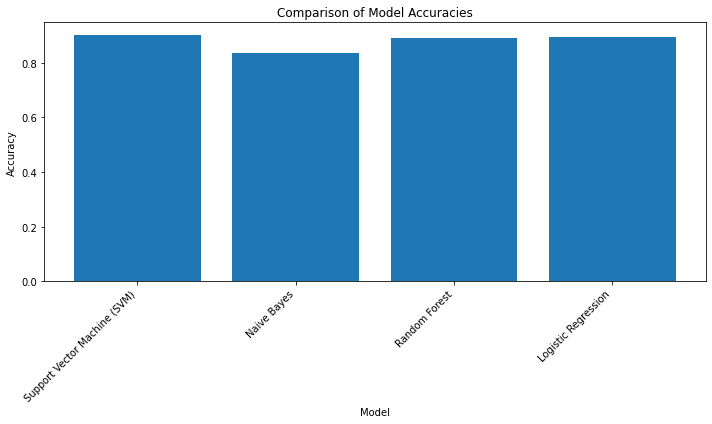

In [81]:
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**SVM has the highest accuracy: 0.9027**